In [1]:
%pylab inline

import pandas as pd
from pandas import DataFrame, Series
from pandas.tseries.offsets import DateOffset
import numpy as np


states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

Populating the interactive namespace from numpy and matplotlib


## Load polling data from The Economist archive

- Discard polls older than two months
- Convert Biden and Trump to major-party vote share

In [2]:
polls = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ56fySJKLL18Lipu1_i3ID9JE06voJEz2EXm6JW4Vh11zmndyTwejMavuNntzIWLY0RyhA1UsVEen0/pub?gid=0&single=true&output=csv')

In [3]:
polls.loc[polls[polls['end.date'] == '108/2020'].index,'end.date'] = '10/8/2020'

In [4]:
polls['state'] = polls.state.replace({'--': 'national'})
polls = polls.sort_values("state")

In [5]:
polls[polls['state'] == 'RI']

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes


In [6]:
keep_states = [state for state in polls['state'].unique() 
               if polls[(pd.to_datetime(polls['end.date']) > (pd.to_datetime("11/2/2020") - DateOffset(months=2)))][polls['state'] == state].shape[0] == 0   ]

/Users/coding/Documents/MDST/election-prediction/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
keep_states

['TN']

In [8]:
keep_polls = polls[polls['state'].isin(keep_states)]

In [9]:
polls = polls[(pd.to_datetime(polls['end.date']) > (pd.to_datetime("11/2/2020") - DateOffset(months=2)))]

In [10]:
polls.append(keep_polls)
polls = polls.sort_values("state")

In [11]:
polls['biden20'] = polls['biden']/(polls['biden'] + polls['trump'])
polls['trump20'] = polls['trump']/(polls['biden'] + polls['trump'])

print('Polls within the past 2 months: %s'%polls.shape[0])

Polls within the past 2 months: 783


In [12]:
polls['end.date.dt'] = pd.to_datetime(polls['end.date'])

In [13]:
polls.sort_values('end.date.dt', ascending = False).head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
36,NC,Ipsos,NaN,10/27/2020,11/2/2020,11/2/2020 17:18:00,707,lv,Online,49,48,1,3.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.505155,0.494845,2020-11-02
37,FL,Ipsos,NaN,10/27/2020,11/2/2020,11/2/2020 17:18:00,670,lv,Online,50,46,4,2.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.520833,0.479167,2020-11-02
35,AZ,Ipsos,NaN,10/27/2020,11/2/2020,11/2/2020 17:18:00,610,lv,Online,50,47,3,2.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.515464,0.484536,2020-11-02
45,national,YouGov,Economist,10/31/2020,11/2/2020,11/2/2020 17:18:00,1363,lv,Online,53,43,10,NaN,NaN,https://docs.cdn.yougov.com/jsojry0vph/econTab...,True,NaN,0.552083,0.447917,2020-11-02
1,ME,Change Research,NaN,10/29/2020,11/2/2020,11/2/2020 23:42:00,1024,lv,Online,52,40,12,6.0,NaN,https://docs.google.com/spreadsheets/d/1TyQc9r...,True,NaN,0.565217,0.434783,2020-11-02


## Average the polls in each state, and nationally

In [14]:
state_mean = {}

for state in polls.state.unique():
    state_polls = polls[polls.state == state]
    state_mean[state] = {'biden20': state_polls.biden20.mean(),
                         'trump20': state_polls.trump20.mean()}

state_mean = DataFrame(state_mean).T.sort_index()
print('Number of states with recent polls: %s'%(state_mean.shape[0]-1))

Number of states with recent polls: 46


In [15]:
state_mean.tail()

,biden20,trump20
WA,0.617852,0.382148
WI,0.540262,0.459738
WV,0.408001,0.591999
WY,0.344444,0.655556
national,0.550624,0.449376


## Fill in values for states with no polls

- Calculate national swing to Biden from 2016 to 2020
- Add that to Clinton's 2016 result for states with no polls

In [16]:
clinton16_national = 48.2/(48.2 + 46.1)

national_swing_to_biden = state_mean.biden20['national'] - clinton16_national

print('National swing from Clinton 2016 to Biden 2020: %s'%national_swing_to_biden.round(4))

National swing from Clinton 2016 to Biden 2020: 0.0395


In [17]:
election_data_url = 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/potus_results_76_16.csv'
election_data = pd.read_csv(election_data_url)
election_2016 = election_data[election_data.year == 2016].set_index('state')
election_2016['clinton16'] = election_2016['dem']/(election_2016['dem'] + election_2016['rep'])
election_2016['trump16'] = election_2016['rep']/(election_2016['dem'] + election_2016['rep'])

election_2016.head()

,year,total_votes,dem,rep,other,clinton16,trump16
state,,,,,,,
AK,2016,318608,0.365509,0.512815,0.092797,0.416143,0.583857
AL,2016,2123372,0.343579,0.620831,0.025364,0.356259,0.643741
AR,2016,1130635,0.336531,0.605741,0.057728,0.357149,0.642851
AZ,2016,2573165,0.451260,0.486716,0.054669,0.481100,0.518900
CA,2016,14181595,0.617264,0.316171,0.058051,0.661282,0.338718


In [18]:
state_mean = state_mean.reindex(election_2016.index)

state_mean['biden20_filled'] = [(election_2016.clinton16[state] + national_swing_to_biden) if pd.isnull(state_mean.biden20[state])
                                else state_mean.biden20[state] for state in state_mean.index]

state_mean['trump20_filled'] = [(election_2016.trump16[state] - national_swing_to_biden) if pd.isnull(state_mean.trump20[state])
                                else state_mean.trump20[state] for state in state_mean.index]

state_mean.head()

,biden20,trump20,biden20_filled,trump20_filled
state,,,,
AK,0.472878,0.527122,0.472878,0.527122
AL,0.402218,0.597782,0.402218,0.597782
AR,0.329897,0.670103,0.329897,0.670103
AZ,0.520092,0.479908,0.520092,0.479908
CA,0.672064,0.327936,0.672064,0.327936


### Use nearest neighbors to correct polls for underpolled states
First, load in the knn results
Go through each state, find states with low polls (say, less than one in the last week). Find a corresponding state with higher polls,
apply the change over time from that state to the state in question.

In [19]:
daysOffset = 14
similarStates = pd.read_csv("knnResults.csv")
similarStates.head()

,0,1,2,3,4
0,AL,SC,TN,AR,MS
1,AK,OR,ID,MT,WY
2,AZ,NV,TX,CA,UT
3,AR,KY,TN,AL,OK
4,CA,NV,AZ,TX,NM


In [20]:
recent_polls = polls[pd.to_datetime(polls['end.date']) > (pd.to_datetime("today") - DateOffset(days=daysOffset))]

recent_polls.head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
165,AK,Gravis Marketing,NaN,10/26/2020,10/28/2020,10/29/2020 8:52:00,770,lv,IVR,43,52,-9,NaN,NaN,https://www.scribd.com/document/482078454/Alas...,True,NaN,0.452632,0.547368,2020-10-28
90,AL,Data for Progress,NaN,10/27/2020,11/1/2020,11/1/2020 21:24:00,1045,lv,Online,38,58,-20,NaN,NaN,https://filesforprogress.org/datasets/2020/11/...,True,NaN,0.395833,0.604167,2020-11-01
204,AZ,Patinkin Research Strategies,NaN,10/21/2020,10/24/2020,10/27/2020 15:13:00,729,lv,Live Phone,52,45,7,NaN,NaN,https://projects.fivethirtyeight.com/polls/202...,True,NaN,0.536082,0.463918,2020-10-24
35,AZ,Ipsos,NaN,10/27/2020,11/2/2020,11/2/2020 17:18:00,610,lv,Online,50,47,3,2.0,NaN,https://www.ipsos.com/sites/default/files/ct/n...,True,NaN,0.515464,0.484536,2020-11-02
43,AZ,Marist College,NBC News,10/29/2020,11/1/2020,11/2/2020 17:18:00,717,lv,Live Phone,48,48,0,NaN,NaN,http://maristpoll.marist.edu/wp-content/upload...,True,NaN,0.500000,0.500000,2020-11-01


In [21]:
#calculate swing in the last [timeframe] for the chosen state
old_polls = polls[pd.to_datetime(polls['end.date']) <= (pd.to_datetime("today") - DateOffset(days=daysOffset))]
old_polls.head()

,state,pollster,sponsor,start.date,end.date,entry.date.time..et.,number.of.observations,population,mode,biden,trump,biden_margin,other,undecided,url,include,notes,biden20,trump20,end.date.dt
355,AK,NYT/Siena College,NaN,10/9/2020,10/14/2020,10/16/2020 14:39:00,423,lv,Live Phone,39,45,-6,8.0,NaN,https://int.nyt.com/data/documenttools/ak10092...,True,NaN,0.464286,0.535714,2020-10-14
570,AK,Harstad Strategic Research Inc.,NaN,9/20/2020,9/23/2020,9/28/2020 17:26:00,602,lv,Live Phone,46,47,-1,NaN,NaN,https://twitter.com/Nat_Herz/status/1310661243...,True,NaN,0.494624,0.505376,2020-09-23
296,AK,Public Policy Polling,NaN,10/19/2020,10/20/2020,10/21/2020 14:50:00,800,rv,IVR,45,50,-5,NaN,NaN,https://www.protectourcare.org/wp-content/uplo...,True,NaN,0.473684,0.526316,2020-10-20
484,AK,Alaska Survey Research,NaN,9/25/2020,10/4/2020,10/6/2020 16:38:00,676,lv,Live Phone,46,50,-4,NaN,NaN,https://twitter.com/IvanMoore1/status/13136483...,True,NaN,0.479167,0.520833,2020-10-04
332,AL,Moore Information,NaN,10/11/2020,10/14/2020,10/19/2020 19:30:00,504,lv,Live Phone,38,55,-17,NaN,NaN,https://www.al.com/news/2020/10/tuberville-cam...,True,NaN,0.408602,0.591398,2020-10-14


In [22]:
state_mean = pd.DataFrame(state_mean)

state_mean['oldbiden20'] = np.nan
state_mean['newbiden20'] = np.nan
state_mean['oldtrump20'] = np.nan
state_mean['newtrump20'] = np.nan
state_mean['bidendifference'] = np.nan

In [23]:


for state in old_polls.state.unique():
    ostate_polls = old_polls[old_polls.state == state]
    state_mean['oldbiden20'][state] = ostate_polls.biden20.mean()
    state_mean['oldtrump20'][state] = ostate_polls.trump20.mean()

for state in recent_polls.state.unique():
    nstate_polls = recent_polls[recent_polls.state == state]
    state_mean['newbiden20'][state] = nstate_polls.biden20.mean()
    state_mean['newtrump20'][state] = nstate_polls.trump20.mean()
for state in state_mean['biden20'].keys():
    state_mean['bidendifference'][state] = state_mean['oldbiden20'][state] - state_mean['newbiden20'][state]
    
print(state_mean)

        biden20   trump20  biden20_filled  trump20_filled  oldbiden20  \
state                                                                   
AK     0.472878  0.527122        0.472878        0.527122    0.477940   
AL     0.402218  0.597782        0.402218        0.597782    0.408602   
AR     0.329897  0.670103        0.329897        0.670103    0.329897   
AZ     0.520092  0.479908        0.520092        0.479908    0.521701   
CA     0.672064  0.327936        0.672064        0.327936    0.672963   
CO     0.556796  0.443204        0.556796        0.443204    0.553751   
CT     0.662338  0.337662        0.662338        0.337662    0.662338   
DC          NaN       NaN        0.996441        0.003559         NaN   
DE     0.620690  0.379310        0.620690        0.379310    0.620690   
FL     0.517348  0.482652        0.517348        0.482652    0.518112   
GA     0.504889  0.495111        0.504889        0.495111    0.503697   
HI     0.685393  0.314607        0.685393        0.

In [24]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference
state,,,,,,,,,
AK,0.472878,0.527122,0.472878,0.527122,0.477940,0.452632,0.522060,0.547368,0.025308
AL,0.402218,0.597782,0.402218,0.597782,0.408602,0.395833,0.591398,0.604167,0.012769
AR,0.329897,0.670103,0.329897,0.670103,0.329897,NaN,0.670103,NaN,NaN
AZ,0.520092,0.479908,0.520092,0.479908,0.521701,0.516778,0.478299,0.483222,0.004922
CA,0.672064,0.327936,0.672064,0.327936,0.672963,0.666667,0.327037,0.333333,0.006296
CO,0.556796,0.443204,0.556796,0.443204,0.553751,0.564917,0.446249,0.435083,-0.011166
CT,0.662338,0.337662,0.662338,0.337662,0.662338,NaN,0.337662,NaN,NaN
DC,NaN,NaN,0.996441,0.003559,NaN,NaN,NaN,NaN,NaN
DE,0.620690,0.379310,0.620690,0.379310,0.620690,NaN,0.379310,NaN,NaN


In [25]:
recent_polls.state.unique()

array(['AK', 'AL', 'AZ', 'CA', 'CO', 'FL', 'GA', 'IA', 'IL', 'IN', 'KS',
       'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'NH', 'NJ',
       'NM', 'NV', 'NY', 'OH', 'PA', 'SC', 'TX', 'UT', 'VA', 'WI', 'WY',
       'national'], dtype=object)

In [26]:
# count polls in each state, store which states have few
nopollstates = [state for state in states if state not in recent_polls.state.unique()]
lowpollstates = [state for state in recent_polls.state.unique() 
                 if recent_polls[recent_polls['state'] == state].shape[0] < 2]


In [27]:
lowpollstates = nopollstates + lowpollstates

In [28]:
len(lowpollstates)

29

In [29]:
# impute polling average for states with low numbers of polls

In [30]:
similarStates

,0,1,2,3,4
0,AL,SC,TN,AR,MS
1,AK,OR,ID,MT,WY
2,AZ,NV,TX,CA,UT
3,AR,KY,TN,AL,OK
4,CA,NV,AZ,TX,NM
5,CO,KS,NE,MN,OR
6,CT,NH,NC,VA,PA
7,DC,PA,VA,MD,NY
8,DE,MD,VA,MA,NY
9,FL,IL,NY,DC,RI


In [31]:
state_mean.loc['AL','biden20']

0.4022177419354839

In [32]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference
state,,,,,,,,,
AK,0.472878,0.527122,0.472878,0.527122,0.477940,0.452632,0.522060,0.547368,0.025308
AL,0.402218,0.597782,0.402218,0.597782,0.408602,0.395833,0.591398,0.604167,0.012769
AR,0.329897,0.670103,0.329897,0.670103,0.329897,NaN,0.670103,NaN,NaN
AZ,0.520092,0.479908,0.520092,0.479908,0.521701,0.516778,0.478299,0.483222,0.004922
CA,0.672064,0.327936,0.672064,0.327936,0.672963,0.666667,0.327037,0.333333,0.006296
CO,0.556796,0.443204,0.556796,0.443204,0.553751,0.564917,0.446249,0.435083,-0.011166
CT,0.662338,0.337662,0.662338,0.337662,0.662338,NaN,0.337662,NaN,NaN
DC,NaN,NaN,0.996441,0.003559,NaN,NaN,NaN,NaN,NaN
DE,0.620690,0.379310,0.620690,0.379310,0.620690,NaN,0.379310,NaN,NaN


In [33]:
for index, row in similarStates.iterrows():
    if row[0] in lowpollstates and row[0] != 'DC':
        for sim_state in row[1:]:
            if sim_state not in lowpollstates:
                state_mean.loc[row[0],'biden20_final'] = state_mean.loc[row[0],'biden20'] + state_mean.loc[row[0],'bidendifference']
                break
        state_mean.loc[row[0],'biden20_final'] = state_mean.loc[row[0],'biden20_filled']
    else:
        state_mean.loc[row[0],'biden20_final'] = state_mean.loc[row[0],'biden20_filled']

In [34]:
for index, row in state_mean.iterrows():
    if pd.isnull(row['biden20_final']):
        state_mean.loc[index,'biden20_final'] = state_mean.loc[index,'biden20_filled']

In [35]:
state_mean

,biden20,trump20,biden20_filled,trump20_filled,oldbiden20,newbiden20,oldtrump20,newtrump20,bidendifference,biden20_final
state,,,,,,,,,,
AK,0.472878,0.527122,0.472878,0.527122,0.477940,0.452632,0.522060,0.547368,0.025308,0.472878
AL,0.402218,0.597782,0.402218,0.597782,0.408602,0.395833,0.591398,0.604167,0.012769,0.402218
AR,0.329897,0.670103,0.329897,0.670103,0.329897,NaN,0.670103,NaN,NaN,0.329897
AZ,0.520092,0.479908,0.520092,0.479908,0.521701,0.516778,0.478299,0.483222,0.004922,0.520092
CA,0.672064,0.327936,0.672064,0.327936,0.672963,0.666667,0.327037,0.333333,0.006296,0.672064
CO,0.556796,0.443204,0.556796,0.443204,0.553751,0.564917,0.446249,0.435083,-0.011166,0.556796
CT,0.662338,0.337662,0.662338,0.337662,0.662338,NaN,0.337662,NaN,NaN,0.662338
DC,NaN,NaN,0.996441,0.003559,NaN,NaN,NaN,NaN,NaN,0.996441
DE,0.620690,0.379310,0.620690,0.379310,0.620690,NaN,0.379310,NaN,NaN,0.620690


## Add COV to mean share of vote

In [36]:
cov = pd.read_csv("covIndex.csv")
cov = cov.set_index('state_abrv')
cov.head()

,registration deadline,starting day of voting early,id for in person voting,who can request,deadline to request,absentee mailed out,date to return absentee by,witness needed,regScore,earlyVoteScore,idScore,requestScore,absenteeMailScore,witnessScore,requestDateScore,returnScore,whoRequestScore,covIndex
state_abrv,,,,,,,,,,,,,,,,,,
AK,2020-10-04,2020-10-19,1,1,2020-10-24,1,2020-11-03,0,1.000000,0.688889,0.5,0.5,0.5,0,0.692308,0.0,0.5,-0.155556
AL,2020-10-19,2020-11-02,1,0,2020-10-29,2,2020-11-03,1,0.500000,1.000000,0.5,0.0,1.0,1,0.307692,0.0,0.0,0.000000
AR,2020-10-05,2020-10-19,2,1,2020-11-02,2,2020-11-03,0,0.966667,0.688889,1.0,0.5,1.0,0,0.000000,0.0,0.5,0.327778
AZ,2020-10-15,2020-10-07,1,0,2020-10-23,1,2020-11-03,0,0.633333,0.422222,0.5,0.0,0.5,0,0.769231,0.0,0.0,-0.972222
CA,2020-11-03,2020-10-05,0,0,2020-11-02,0,2020-11-03,0,0.000000,0.377778,0.0,0.0,0.0,0,0.000000,0.0,0.0,-1.811111


In [37]:

for index, row in state_mean.iterrows():
    row['biden20_final'] = row['biden20_final'] - cov.covIndex[index]/100
   
    #print(index)
    #print(row['biden20_filled'])
    #print(cov.covIndex[index]/100)
    #print(row['biden20_filled_cov'])
#state_mean['biden20_filled_cov'] = state_mean['biden20_filled'] - cov["covIndex"][state]
#state_mean['trump20_filled_cov'] = state_mean['trump20_filled'] - cov["covIndex"][state]

## Visualize current poll aggregates

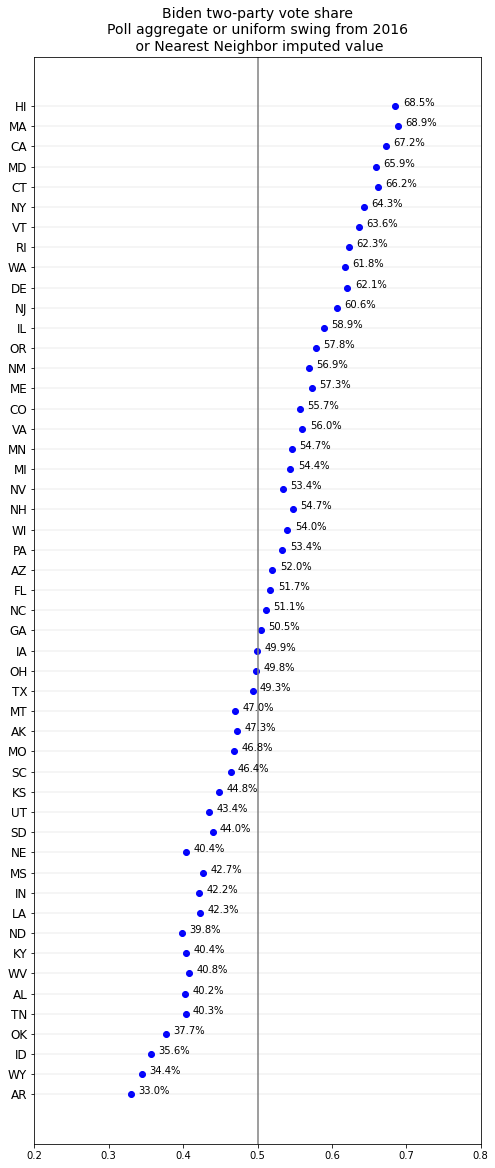

In [38]:
figsize(8,20)

# Don't plot DC
state_mean_sorted = (state_mean.sort_values('biden20_final'))[:-1]

plt.xlim(0.2,0.8)
plt.title('Biden two-party vote share\nPoll aggregate or uniform swing from 2016\n or Nearest Neighbor imputed value', fontsize = 14)
plt.yticks(arange(50), state_mean_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(state_mean_sorted.biden20_filled, arange(50), color = 'blue');
for i, state in enumerate(state_mean_sorted.index):
    axhline(i, color = 'gray', alpha = 0.1);
    text(state_mean_sorted.biden20_filled[state] + 0.01, i, 
         '%s%%'%(100*state_mean_sorted.biden20_filled[state]).round(1));

## Compute Covid Uncertainty

In [39]:
df = pd.read_csv('united_states_covid19_cases_and_deaths_by_state - united_states_covid19_cases_and_deaths_by_state.csv')

df = df[["State/Territory","Case Rate per 100000 in Last 7 Days"]]

state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

territories = [state for state in df["State/Territory"].unique() if state not in state_names]

df = df[~df["State/Territory"].isin(territories)]

df = df.reset_index(drop=True)

arr = (df["Case Rate per 100000 in Last 7 Days"] - df["Case Rate per 100000 in Last 7 Days"].mean())/df["Case Rate per 100000 in Last 7 Days"].std(ddof=0)

arr += 1
for x in range(0,50):
    if arr[x] < 1:
        arr[x] = 1
    elif arr[x] > 2:
        arr[x] = 2
df['Adjusted Z-Score'] = arr

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df["State/Territory"] = states
df = df[["State/Territory", "Adjusted Z-Score"]]
zscore = df.set_index("State/Territory")

In [40]:
zscore

,Adjusted Z-Score
State/Territory,
AL,1.830273
AK,1.185144
AZ,1.080415
AR,1.000000
CA,1.000000
CO,1.000000
CT,1.000000
DC,1.000000
DE,1.000000


## Simulate election outcome

Increasing the amount of uncertainty in the state poll average and/or the national polling error shifts the probability of winning towards 0.5.

In [41]:
electoral_votes = DataFrame.from_dict({'AL': 9, 'AK': 3, 'AZ': 11, 'AR': 6, 'CA': 55, 'CO': 9,
                                       'CT': 7, 'DE': 3, 'FL': 29, 'GA': 16, 'HI': 4, 'ID': 4,
                                       'IL': 20, 'IN': 11, 'IA': 6, 'KS': 6, 'KY': 8, 'LA': 8,
                                       'ME': 4, 'MD': 10, 'MA': 11, 'MI': 16, 'MN': 10, 'MS': 6,
                                       'MO': 10, 'MT': 3, 'NE': 5, 'NV': 6, 'NH': 4, 'NJ': 14,
                                       'NM': 5, 'NY': 29, 'NC': 15, 'ND': 3, 'OH': 18, 'OK': 7,
                                       'OR': 7, 'PA': 20, 'RI': 4, 'SC': 9, 'SD': 3, 'TN': 11,
                                       'TX': 38, 'UT': 6, 'VT': 3, 'VA': 13, 'WA': 12, 'WV': 5,
                                       'WI': 10, 'WY': 3, 'DC': 3},
                                      orient='index', columns = ['EV'])

In [42]:
# Simulation settings
number_of_simulations = 10000

# Uncertainty in state forecasts, around poll average
state_uncertainty_sd = 0.05

# Uncertainty in national forecasts; correlated error with mean zero
national_uncertainty_sd = 0.03

In [43]:
#
#
#
#
#
biden_state_wins = Series(0, index = state_mean.index)
biden_state_votes = DataFrame()
biden_ev_sim = []

#for sim in arange(number_of_simulations):
#    # simulate 51 state-level election outcomes
#    national_error = np.random.normal(0, national_uncertainty_sd)
#    one_simulation = DataFrame({'state': state_mean.index,
#                                'biden_vote': np.random.normal(state_mean.biden20_filled, state_uncertainty_sd) +
#                                              national_error}).set_index('state')

for sim in arange(number_of_simulations):
    # simulate 51 state-level election outcomes
    national_error = np.random.normal(0, national_uncertainty_sd)
    biden_vote = {}
    for state, row in state_mean.iterrows():
        biden_vote[state] =  np.random.normal(row['biden20_filled'], zscore["Adjusted Z-Score"][state]*state_uncertainty_sd) + national_error
    one_simulation = DataFrame({'state': state_mean.index}).set_index('state')
    s = pd.Series(biden_vote)
    one_simulation = one_simulation.assign(biden_vote = s.values)
    
    # did Biden win each state in this simulation?
    one_simulation['biden_win'] = (one_simulation.biden_vote > 0.5)+0
    
    # record simulation results
    one_simulation = one_simulation.merge(electoral_votes, left_index = True, right_index = True)
#    print(one_simulation)
    biden_state_wins = biden_state_wins + one_simulation.biden_win
#    print(biden_state_wins)
    biden_state_votes = biden_state_votes.append(one_simulation.biden_vote)
#    print(biden_state_votes)
    biden_ev_sim = biden_ev_sim + [(one_simulation.biden_win * one_simulation.EV).sum()]
#    print(biden_ev_sim)


## Visualize simulation results and chance of winning each state and nationally

- Black line: The result needed to win
- Red line: Simulation average

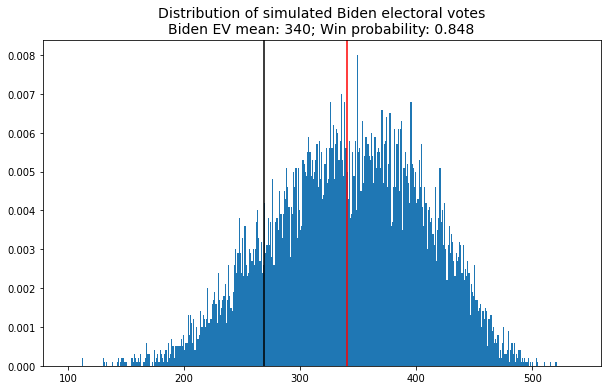

In [44]:
figsize(10,6)
plt.hist(biden_ev_sim, bins = arange(100, 538, 1), density = True);
biden_ev_forecast = int(np.array(biden_ev_sim).mean())
plt.title('Distribution of simulated Biden electoral votes\nBiden EV mean: %s; Win probability: %s'%
          (biden_ev_forecast, (np.array(biden_ev_sim) > 269).mean().round(3)), fontsize = 14);
axvline(269, color = 'black');
axvline(biden_ev_forecast, color = 'red');

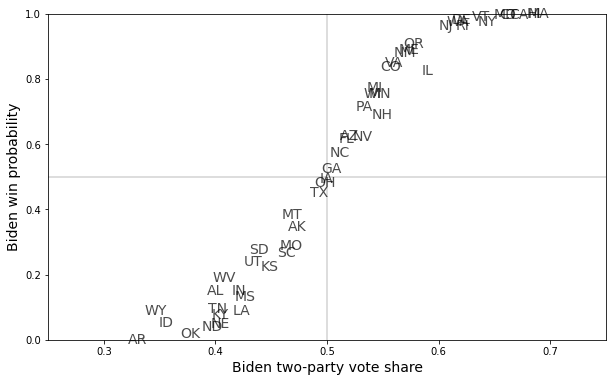

In [45]:
figsize(10,6)
plt.xlim(0.25, 0.75)
plt.xlabel('Biden two-party vote share', fontsize = 14)
plt.ylabel('Biden win probability', fontsize = 14)

biden_state_win_prob = biden_state_wins / number_of_simulations
for state in state_mean.index:
    if state != 'DC':
        plt.text(biden_state_votes.mean()[state],
                 biden_state_win_prob[state],
                 state, ha = 'center', va = 'center', 
                 fontsize = 14, alpha = 0.7)
        
axvline(0.5, color = 'lightgray');
axhline(0.5, color = 'lightgray');

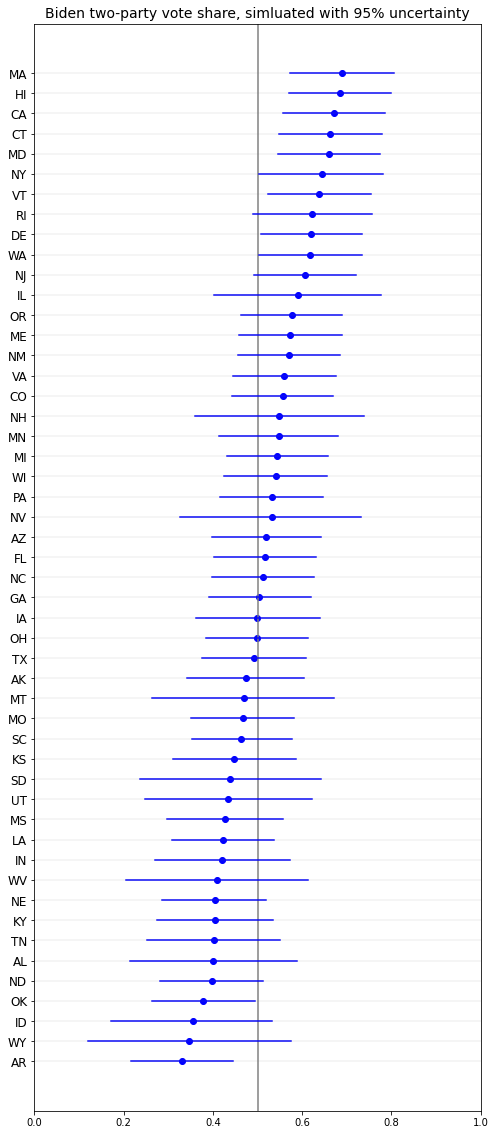

In [46]:
figsize(8,20)

biden_state_votes_sorted = biden_state_votes.mean().sort_values()[:-1]

plt.xlim(0,1)
plt.title('Biden two-party vote share, simluated with 95% uncertainty', fontsize = 14)
plt.yticks(arange(50), biden_state_votes_sorted.index, fontsize = 12)
axvline(0.5, color = 'gray');

plt.scatter(biden_state_votes_sorted, arange(50), color = 'blue');
for i, state in enumerate(biden_state_votes_sorted.index):
    plt.plot([biden_state_votes[state].quantile(0.025), 
              biden_state_votes[state].quantile(0.975)],
              [i, i], color = 'blue');
    axhline(i, color = 'gray', alpha = 0.1);

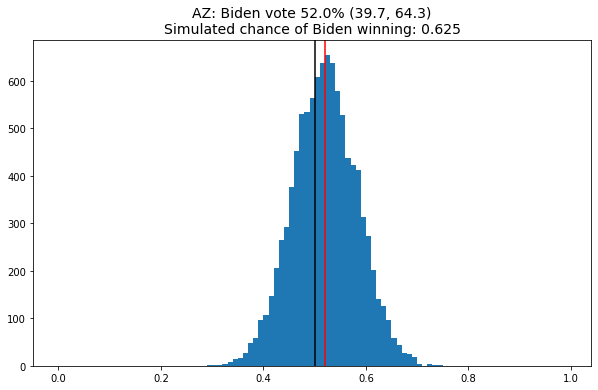

In [47]:
plot_state = 'AZ'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');

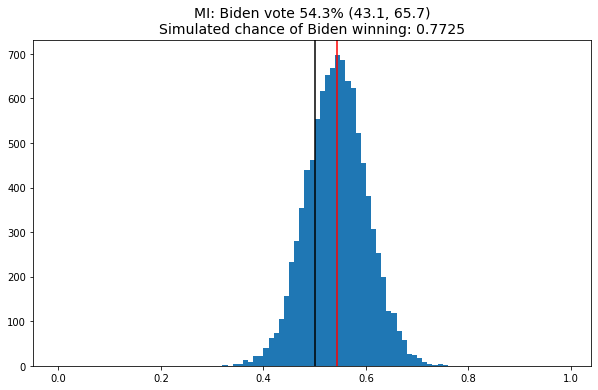

In [48]:
plot_state = 'MI'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');

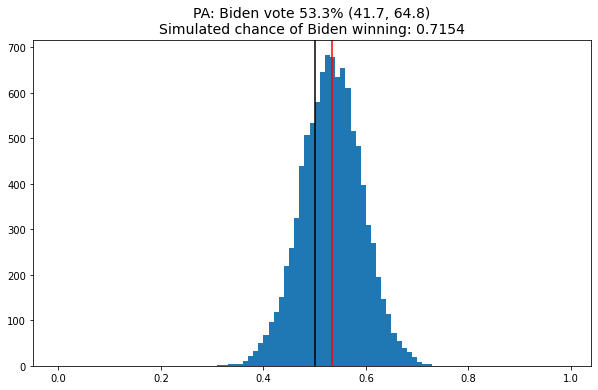

In [49]:
plot_state = 'PA'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');

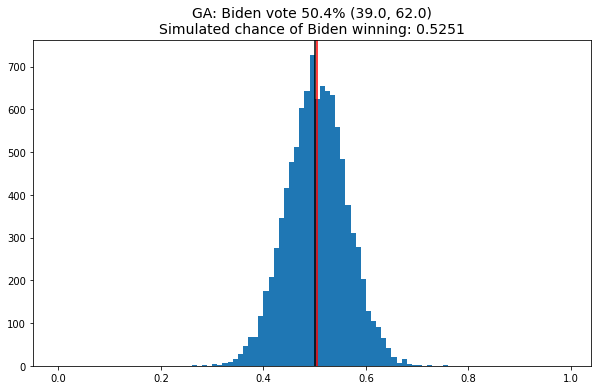

In [50]:
plot_state = 'GA'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');

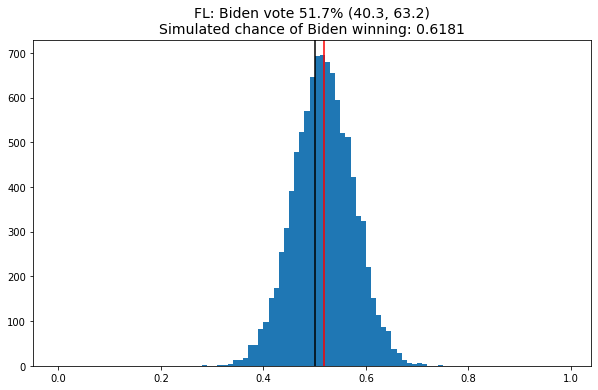

In [51]:
plot_state = 'FL'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');

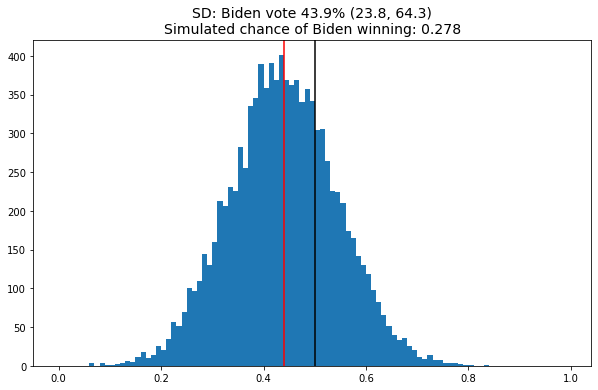

In [52]:
plot_state = 'SD'

figsize(10,6)
plt.hist(biden_state_votes[plot_state], bins = arange(0,1,0.01));
plt.title('%s: Biden vote %s%% (%s, %s)\nSimulated chance of Biden winning: %s'%(plot_state,
                                                   np.round((100*biden_state_votes[plot_state].mean()),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.025)),1),
                                                   np.round((100*biden_state_votes[plot_state].quantile(0.975)),1),
                                                   biden_state_win_prob[plot_state]),
          fontsize = 14)
axvline(0.5, color = 'black');
axvline(biden_state_votes[plot_state].mean(), color = 'red');